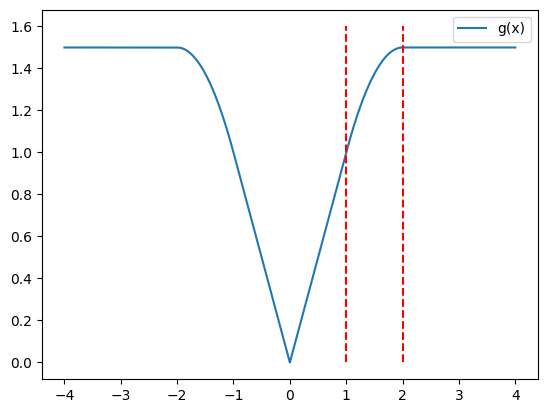

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import math

def func(theta, gamma1, gamma2):
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

gamma1, gamma2 = 1, 2
x = np.linspace(-4, 4, 100000)
y = [func(i, gamma1, gamma2) for i in x]

plt.plot(x, y, label='g(x)')
plt.vlines(1, 0, 1.6, colors = "r", linestyles = "dashed")
plt.vlines(2, 0, 1.6, colors = "r", linestyles = "dashed")
plt.legend()
plt.show()

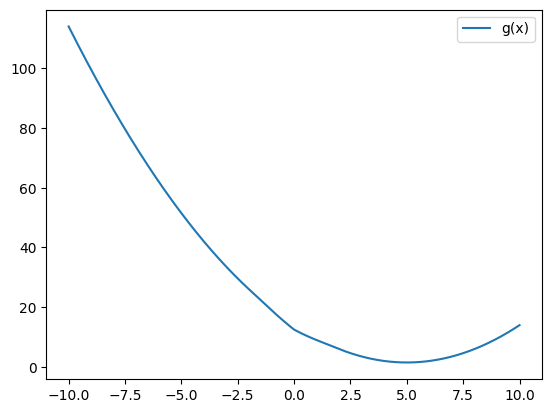

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import math

def func(theta, gamma1, gamma2):
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

gamma1, gamma2 = 1, 2
x = np.linspace(-10, 10, 100000)
y = [func(i, gamma1, gamma2) + 0.5 * (i - 5) * (i - 5) for i in x]

plt.plot(x, y, label='g(x)')
plt.legend()
plt.show()

M: [10.22, 10.22, 10.22, 10.22, 10.22, 10.16]
Epoch 0, Mean Squared Error: 12.64
M: [10.22, 10.22, 10.22, 10.22, 10.16, 5.35]
Epoch 1, Mean Squared Error: 11.22
M: [10.22, 10.22, 10.22, 10.16, 5.35, 4.7]
Epoch 2, Mean Squared Error: 10.81
M: [10.22, 10.22, 10.16, 5.35, 4.7, 4.26]
Epoch 3, Mean Squared Error: 10.15
M: [10.22, 10.16, 5.35, 4.7, 4.26, 3.94]
Epoch 4, Mean Squared Error: 9.40
M: [10.16, 5.35, 4.7, 4.26, 3.94, 4.39]
Epoch 5, Mean Squared Error: 8.28
M: [5.35, 4.7, 4.26, 3.94, 4.39, 3.8]
Epoch 6, Mean Squared Error: 8.25
M: [4.7, 4.26, 3.94, 4.39, 3.8, 3.61]
Epoch 7, Mean Squared Error: 7.97
M: [4.26, 3.94, 4.39, 3.8, 3.61, 3.58]
Epoch 8, Mean Squared Error: 7.82
M: [3.94, 4.39, 3.8, 3.61, 3.58, 3.51]
Epoch 9, Mean Squared Error: 7.14
M: [4.39, 3.8, 3.61, 3.58, 3.51, 3.57]
Epoch 10, Mean Squared Error: 6.51
M: [3.8, 3.61, 3.58, 3.51, 3.57, 3.66]
Epoch 11, Mean Squared Error: 6.00
M: [3.61, 3.58, 3.51, 3.57, 3.66, 3.41]
Epoch 12, Mean Squared Error: 6.00
M: [3.58, 3.51, 3.57, 

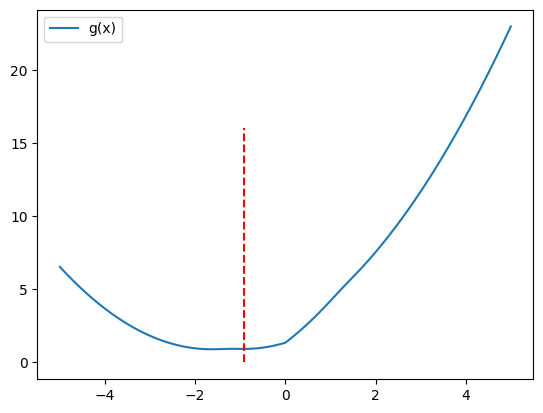

0.923747837331776, 0.9031059618530709
solution: -0.9173283075871224
ut: -1.6398130681770426


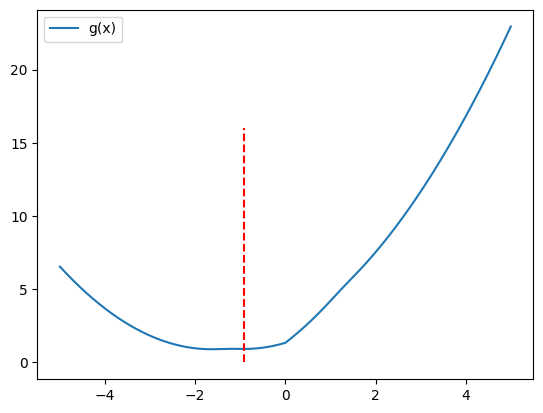

0.9214580369670033, 0.9031059509361803
solution: -0.9141589668761805
ut: -1.6366437274661008


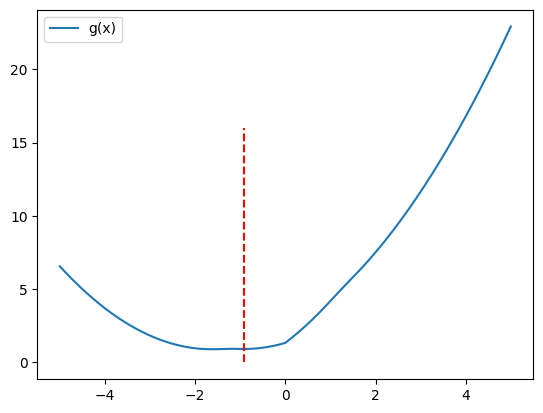

M: [3.57, 3.66, 3.41, 3.41, 3.39, 3.47]
Epoch 15, Mean Squared Error: 4.88
M: [3.66, 3.41, 3.41, 3.39, 3.47, 3.54]
Epoch 16, Mean Squared Error: 4.71
M: [3.41, 3.41, 3.39, 3.47, 3.54, 3.57]
Epoch 17, Mean Squared Error: 4.69
M: [3.41, 3.39, 3.47, 3.54, 3.57, 3.39]
Epoch 18, Mean Squared Error: 4.46
M: [3.39, 3.47, 3.54, 3.57, 3.39, 3.36]
Epoch 19, Mean Squared Error: 4.32
M: [3.47, 3.54, 3.57, 3.39, 3.36, 3.35]
Epoch 20, Mean Squared Error: 4.28
M: [3.54, 3.57, 3.39, 3.36, 3.35, 3.35]
Epoch 21, Mean Squared Error: 4.17
M: [3.57, 3.39, 3.36, 3.35, 3.35, 3.34]
Epoch 22, Mean Squared Error: 4.00
M: [3.39, 3.36, 3.35, 3.35, 3.34, 3.36]
Epoch 23, Mean Squared Error: 3.81
M: [3.36, 3.35, 3.35, 3.34, 3.36, 3.35]
Epoch 24, Mean Squared Error: 3.87
M: [3.35, 3.35, 3.34, 3.36, 3.35, 3.34]
Epoch 25, Mean Squared Error: 3.79
M: [3.35, 3.34, 3.36, 3.35, 3.34, 3.34]
Epoch 26, Mean Squared Error: 3.79
M: [3.34, 3.36, 3.35, 3.34, 3.34, 3.34]
Epoch 27, Mean Squared Error: 3.77
M: [3.36, 3.35, 3.34, 3.3

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import math

rand_generator = np.random.default_rng(seed=0)

gamma1, gamma2 = 1, 1.5
def penalty_func(theta, gamma1=gamma1, gamma2=gamma2):
    """
    Penalty Function
    theta: scalar, input variable
    """
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

# construct A, x_solution, b
m, n = 2 ** 10, 2 ** 12
# A: shape [m, n], mean 0, variance 1 / 2n
A = rand_generator.normal(0, 1 / math.sqrt(2 * n), (m, n))
x_solution = np.zeros(n)
random_positions = rand_generator.choice(range(n), size=160, replace=False)
for i in random_positions:
    x_solution[i] = rand_generator.choice([-1, 1])
b = np.dot(A, x_solution) + rand_generator.normal(0, 1 / math.sqrt(10**4), m)

# parameter of non-convex penalty function
mu = 0.1 * np.linalg.norm(np.dot(A.transpose(), b), ord=np.inf)  # coeff of penalty function
alpha_max, alpha_min = 10 ** 30, 1 / 10 ** 30
eta = 2
sigma = 0.01

def main_func(theta):
    """
    Main Objective Funtion
    theta: vector, input variable
    """
    fx = 0.5 * (np.linalg.norm(np.dot(A, theta) - b) ** 2)
    gx = sum([penalty_func(i) for i in theta])
    return fx + mu * gx

def solve_sub(ut, alpha):
    negative = True if ut < 0 else False
    ut_pos = abs(ut)

    # find solution for ut_pos
    solution_set = []
    # (0, gamma1)
    if ut_pos - mu / alpha <= 0:
        solution_set.append(0)
    elif ut_pos - mu / alpha <= gamma1:
        solution_set.append(ut_pos - mu / alpha)
    else:
        solution_set.append(gamma1)
    # (gamma1, gamma2)
    a = 1 - mu / (alpha * (gamma2 - gamma1))
    z = (ut_pos - mu / alpha * gamma2 / (gamma2 - gamma1)) / a
    if a <= 0:
        solution_set.append(gamma1)
        solution_set.append(gamma2)
    else:
        if z <= gamma1:
            solution_set.append(gamma1)
        elif z <= gamma2:
            solution_set.append(z)
        else:
            solution_set.append(gamma2)
    # (gamma2, +∞)
    if ut_pos < gamma2:
        solution_set.append(gamma2)
    else:
        solution_set.append(ut_pos)
    
    def sub_function(theta):
        return 0.5 * (theta - ut) ** 2 + mu / alpha * penalty_func(theta)

    solution = min(solution_set, key=sub_function)
    # print(solution_set, [sub_function(i) for i in solution_set], solution)
    solution = solution if not negative else (- solution)

    # if t > 600:
    # check whether solution is the minimizer
    x = np.linspace(-5, 5, 10000)
    y = [sub_function(i) for i in x]
    if not sub_function(solution) <= min(y) and abs(sub_function(solution) - min(y)) >= 0.01:
        print(f"{sub_function(solution)}, {min(y)}")
        print(f"solution: {solution}")
        print(f"ut: {ut}")
        plt.plot(x, y, label='g(x)')
        plt.vlines(solution, 0, 16, colors = "r", linestyles = "dashed")
        plt.legend()
        plt.show()

    return solution


xt = np.zeros(n)  # initial guess of xt
M_queue = [main_func(xt)] * 6
for t in range(1000):
    # choose alpha_t
    if t != 0:
        # bb step size
        st = xt - x_old  # x_t - x_{t-1}
        alpha = np.linalg.norm(np.dot(A, st)) ** 2 / (np.linalg.norm(st) ** 2)
        assert alpha > alpha_min and alpha < alpha_max
        # print(f"alpha: {alpha}")
    else:
        alpha = 100

    x_old = xt
    # inner loop to find x_{t+1}
    for _ in range(10):
        # solution of sub-problem
        ut = xt - np.matmul(A.transpose(), np.matmul(A, xt) - b) / alpha
        xt = np.array([solve_sub(i, alpha=alpha) for i in ut])

        # alpha update
        alpha *= eta
        
        # if satisfies an acceptance criterion, break
        xt_func = main_func(xt)
        max_func = max(M_queue)
        if xt_func <= max_func - sigma * alpha * (np.linalg.norm(xt - x_old) ** 2) / 2:
            break
    
    M_queue.pop(0)
    M_queue.append(main_func(xt))

    M_output = [round(i, 2) for i in M_queue]
    print(f"M: {M_output}")

    # termination condition
    if np.linalg.norm(xt - x_solution) < 1:
        break

    print(f"Epoch {t}, Mean Squared Error: {np.linalg.norm(xt - x_solution):.2f}")

print(xt)
